# Building a Conditional GAN for creating random handwritten digits
This notebook trains a conditional GAN which is able to generate handwirtten digits using the MNIST dataset. This notebook is inspired by [this](https://medium.com/towards-data-science/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0) blog post.

#### Speed
On Tesla K80 with batch size of 256 and 2000 iterations, the speed is about 1.4it/s and training takes about 23 minutes (TensorFlow backend)

In [1]:
import keras

from keras.models import Sequential

from keras.layers import Conv2D, Flatten, Dropout, Dense, UpSampling2D, Reshape
from keras.layers import Conv2DTranspose, Activation, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop

from keras.datasets import cifar10

Using TensorFlow backend.


In [2]:
%matplotlib inline
import matplotlib.pylab as plt

from tqdm import tnrange
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# Building the Network

In [3]:
# MNIST dataset consists of 28x28 grayscale images
img_rows = 32
img_cols = 32
channel = 3

classes = 10

## Building the Discriminator

In [4]:
depth = 64
dropout = 0.4

In [5]:
discriminator = Sequential()

input_shape = (img_rows, img_cols, channel)

discriminator.add(Conv2D(depth*1, 5, strides=2, 
                         input_shape=input_shape,padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(dropout))

discriminator.add(Conv2D(depth*2, 5, strides=2, padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(dropout))

discriminator.add(Conv2D(depth*4, 5, strides=2, padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(dropout))

discriminator.add(Conv2D(depth*8, 5, strides=1, padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(dropout))

discriminator.add(Flatten())
discriminator.add(Dense(classes + 1))
discriminator.add(Activation('softmax'))

discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
__________

In [6]:
optimizer = RMSprop(lr=0.0008, clipvalue=1.0, decay=6e-8)

discriminator_model = Sequential()
discriminator_model.add(discriminator)

discriminator_model.compile(loss='categorical_crossentropy', 
                            optimizer=optimizer, 
                            metrics=['accuracy'])

## Building the Generator

In [7]:
dropout = 0.4
depth = 64+64+64+64
dim = 8

In [8]:
generator = Sequential()

generator.add(Dense(dim*dim*depth, input_dim=100 + classes))
generator.add(BatchNormalization(momentum=0.9))
generator.add(Activation('relu'))
generator.add(Reshape((dim, dim, depth)))
generator.add(Dropout(dropout))

generator.add(UpSampling2D())
generator.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
generator.add(BatchNormalization(momentum=0.9))
generator.add(Activation('relu'))

generator.add(UpSampling2D())
generator.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
generator.add(BatchNormalization(momentum=0.9))
generator.add(Activation('relu'))

generator.add(Conv2DTranspose(3, 5, padding='same'))
generator.add(Activation('sigmoid'))

generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16384)             1818624   
_________________________________________________________________
batch_normalization_1 (Batch (None, 16384)             65536     
_________________________________________________________________
activation_2 (Activation)    (None, 16384)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 8, 256)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       819328    
__________

## Building the Adverserial
The adversarial model is build by combining both the discriminator and generator

In [9]:
optimizer = RMSprop(lr=0.0004, clipvalue=1.0, decay=3e-8)

adversarial_model = Sequential()
adversarial_model.add(generator)
discriminator.trainable = False
adversarial_model.add(discriminator)

adversarial_model.compile(loss='categorical_crossentropy', 
                          optimizer=optimizer,
                          metrics=['accuracy'])
adversarial_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 32, 32, 3)         2913923   
_________________________________________________________________
sequential_1 (Sequential)    (None, 11)                4396683   
Total params: 7,310,606
Trainable params: 2,880,771
Non-trainable params: 4,429,835
_________________________________________________________________


# Train the Network

In [10]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = np.concatenate((x_train, x_test))
y_train = np.concatenate((y_train, y_test))

In [11]:
def normalize(images):
    images=images.astype('float32')
    if images.max() > 1.0:
        images/=255.0
    return images

In [12]:
def one_hot(labels):
    enc = OneHotEncoder()
    return enc.fit_transform(y_train).toarray()

In [13]:
x_train = normalize(x_train)
y_train = one_hot(y_train)

We create random noise and concatenate it with random class labels

In [14]:
def create_generator_noise(batch_size):
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
    sampling = np.random.randint(classes, size=batch_size)
    noise_labels = np.zeros((batch_size, classes))
    noise_labels[np.arange(batch_size), sampling] = 1
    noise_input = np.concatenate((noise, noise_labels), axis=1)
    
    return noise_input, noise_labels

In [15]:
def create_generator_noise_by_label(labels):
    noise = np.random.uniform(-1.0, 1.0, size=[len(labels), 100])

    noise_labels = np.zeros((len(labels), classes))
    noise_labels[np.arange(len(labels)), labels] = 1
    noise_input = np.concatenate((noise, noise_labels), axis=1)
    
    return noise_input

In [16]:
def train(batch_size=256, train_steps=2000):
    discriminator_losses = []
    adversarial_losses = []
    sample_images = []
    
    for i in tnrange(train_steps):
        # Select a random sample from the training data and the labels
        sample_idx = np.random.randint(0, x_train.shape[0], size=batch_size)
        images_train = x_train[sample_idx, :, :, :]
        labels_train = y_train[sample_idx]
        labels_train = np.concatenate((labels_train, np.zeros(shape=(batch_size, 1))), axis=1)
        
        # Create noise in range -1 to 1 and random labels as input for the generator to generate the fake images
        noise_input, _ = create_generator_noise(batch_size)
        images_fake = generator.predict(noise_input)
        
        # Create input by concatenate both real and fake images and assigning the respective labels
        labels_fake = np.zeros(shape=(batch_size, classes+1))
        labels_fake[:,-1] = 1
        
        input_data   = np.concatenate((images_train, images_fake))
        input_labels = np.concatenate((labels_train, labels_fake))

        discriminator_loss = discriminator_model.train_on_batch(input_data, input_labels)
        
        # Train the adversarial model to generate better images
        noise_input, noise_labels = create_generator_noise(batch_size)
        noise_labels = np.concatenate((noise_labels, np.zeros(shape=(batch_size, 1))), axis=1)
        
        adversarial_loss = adversarial_model.train_on_batch(noise_input, noise_labels)
        
        discriminator_losses.append(discriminator_loss)
        adversarial_losses.append(adversarial_loss)
        
        if i % 100 == 0:
            labels = [1]
            noise = create_generator_noise_by_label(labels)
            fake_images = generator.predict(noise)
            sample_images.append(fake_images[0])
    
    return discriminator_losses, adversarial_losses, sample_images

In [17]:
discriminator_losses, adversarial_losses, sample_images  = train(train_steps=20000)

A Jupyter Widget

## Plot Evolution of Generated Images (Cars)

In [33]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

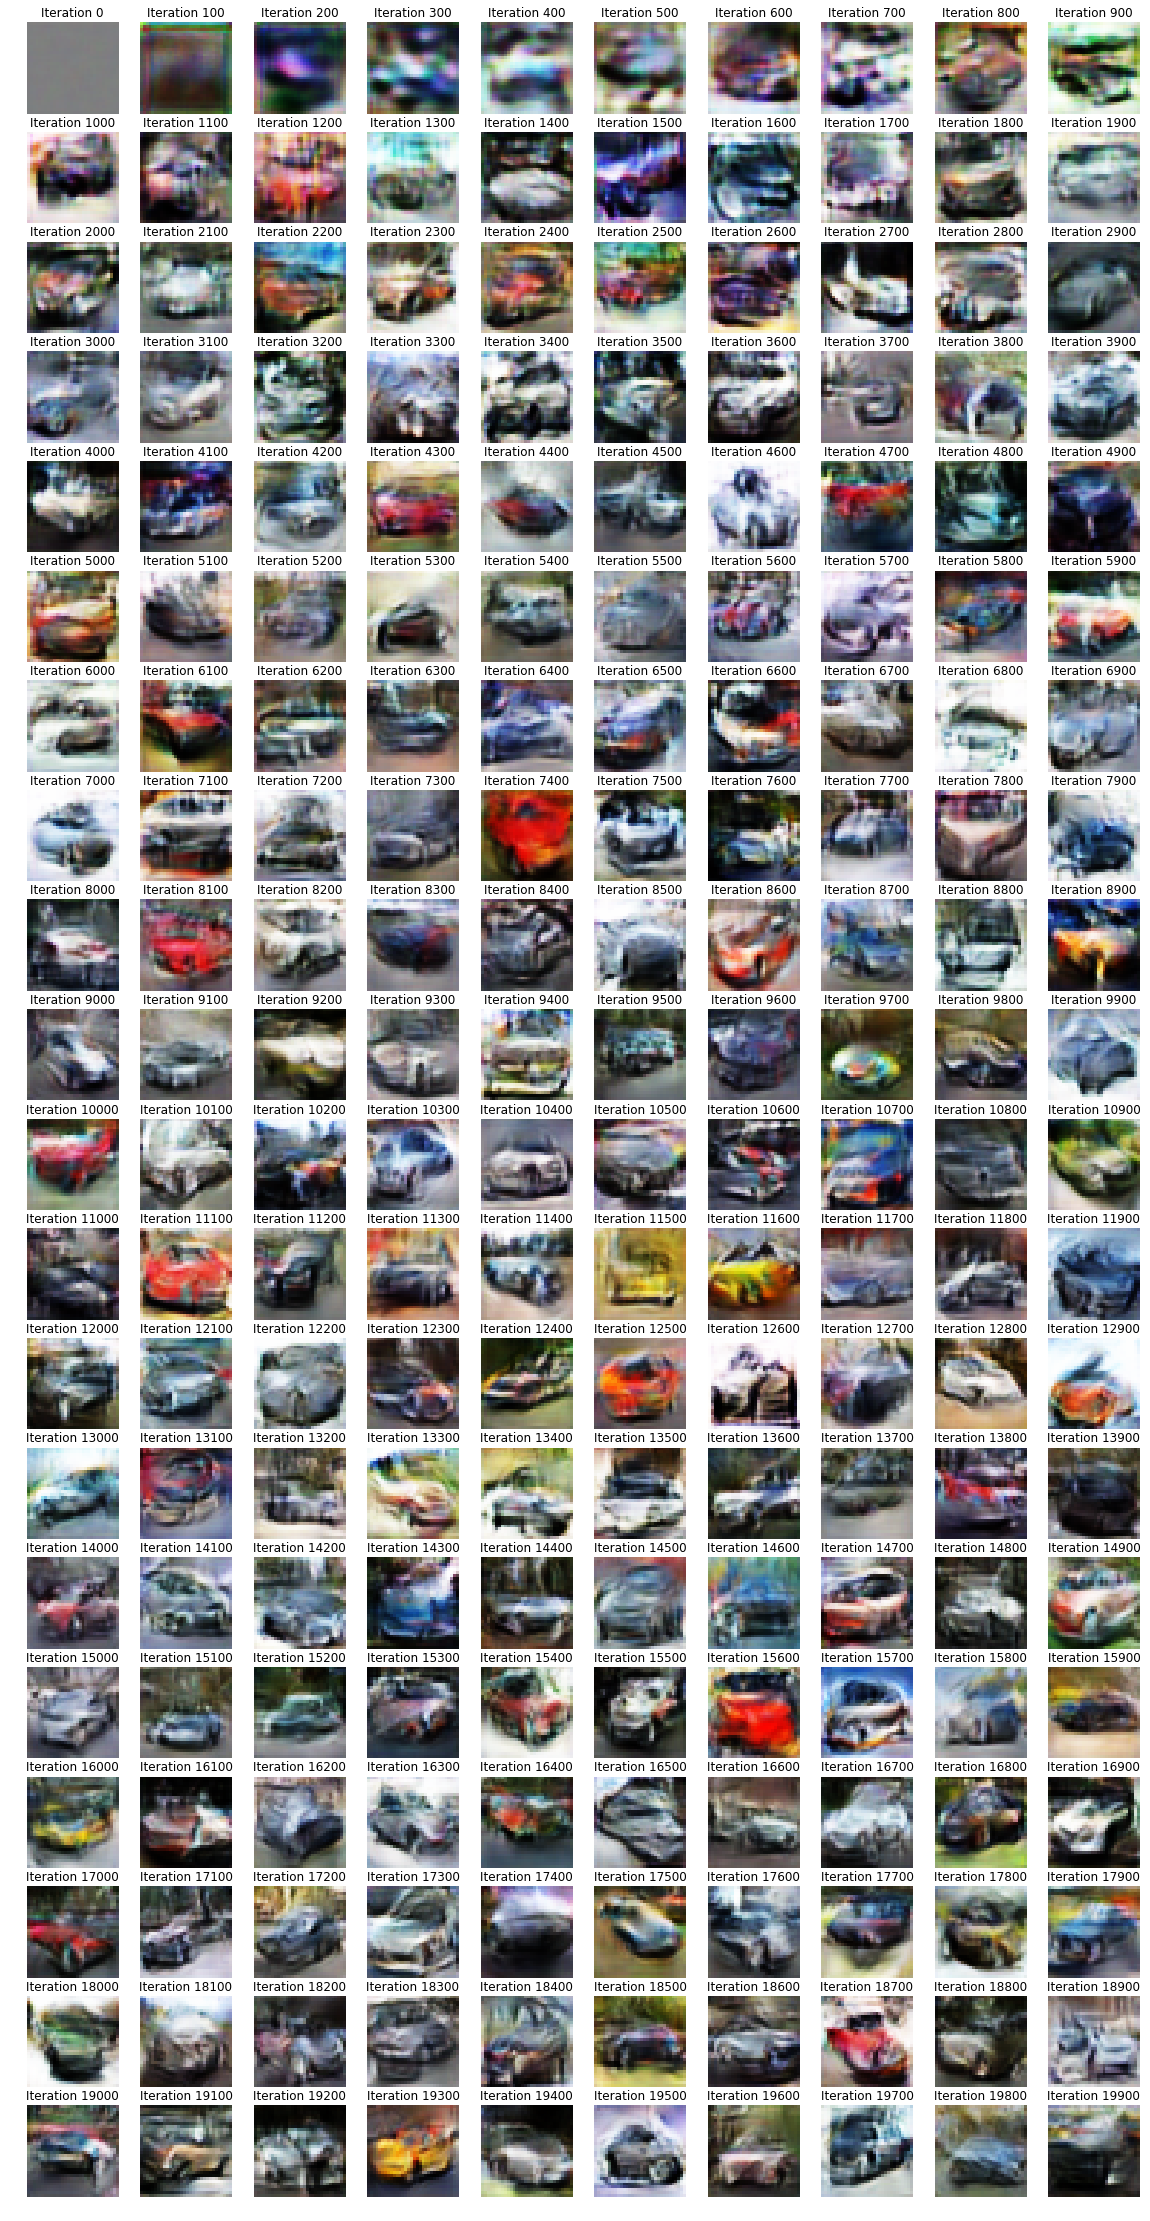

In [34]:
plt.figure(figsize=(20,40))
for i, fake_image in enumerate(sample_images, 0):
    plt.subplot(20, 10, i+1)
    plt.imshow(np.reshape(fake_image, (img_cols, img_rows, channel)), cmap='gray')
    plt.title("Iteration %d" % (i * 100))
    plt.axis('off')

## Plot Training History

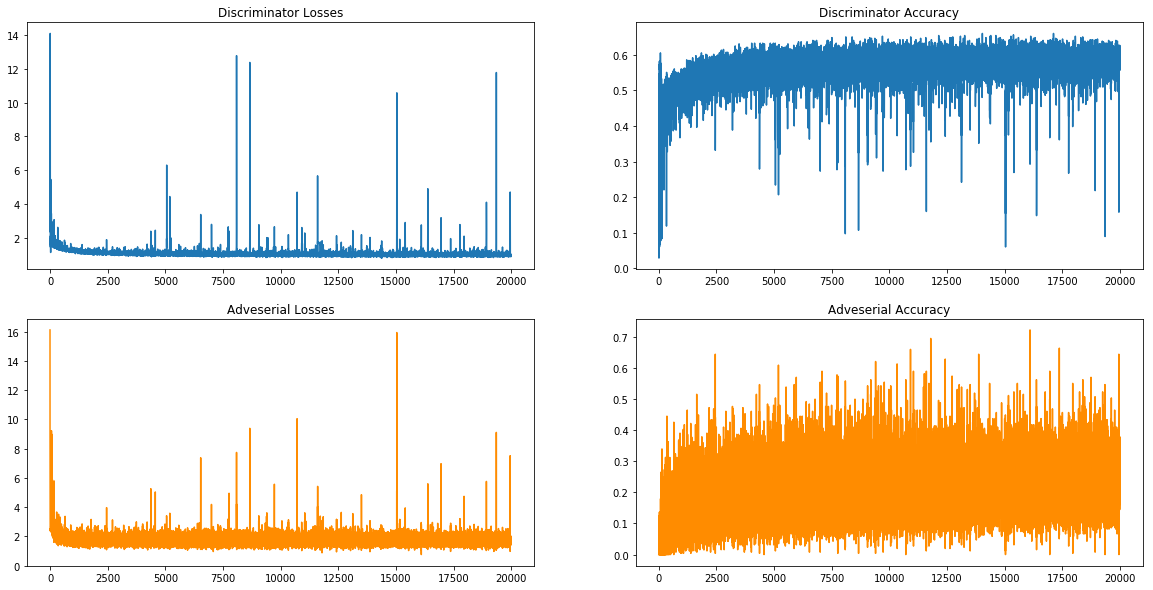

In [19]:
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
plt.plot(np.array(discriminator_losses)[:, 0])
plt.title("Discriminator Losses")

plt.subplot(2,2,2)
plt.plot(np.array(discriminator_losses)[:, 1])
plt.title("Discriminator Accuracy")

plt.subplot(2,2,3)
plt.plot(np.array(adversarial_losses)[:, 0], color='darkorange')
plt.title("Adveserial Losses")

plt.subplot(2,2,4)
plt.plot(np.array(adversarial_losses)[:, 1], color='darkorange')
plt.title("Adveserial Accuracy")

# Generating Images given Class Labels

In [25]:
label_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [68]:
def sample_labels(size):
    labels = []
    for i in range(size):
        labels.append(randint(0, 9))
    return labels

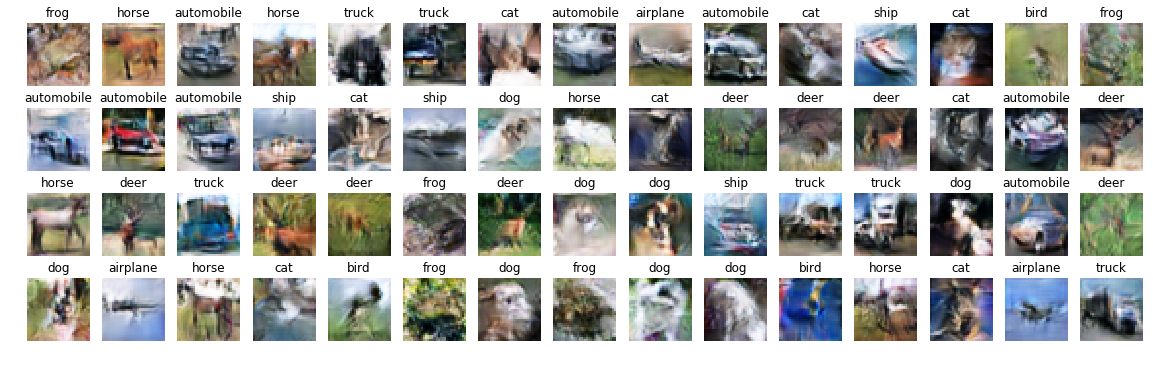

In [76]:
labels = sample_labels(60)
noise = create_generator_noise_by_label(labels)

fake_images = generator.predict(noise)

plt.figure(figsize=(20,6))
for i, fake_image in enumerate(fake_images, 1):
    plt.subplot(4, 15, i)
    plt.imshow(np.reshape(fake_image, (img_cols, img_rows, channel)), cmap='gray')
    plt.title(label_names[labels[i-1]])
    plt.axis('off')